<a href="https://colab.research.google.com/github/gdoorash/Cassava-Disease-Classification/blob/gdoora_side/Notebooks/ResNxet_Pretrained_cassava_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ResNet_Pretrained Architecture**

In [0]:
import numpy
import torch 
import torchvision 
import os
import matplotlib.pyplot as plt
import random 
import pdb
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, sampler
import imageio
import PIL
from IPython import display
from torchvision import datasets
import torch.nn as nn
 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!unzip "/content/gdrive/My Drive/Colab Notebooks/Data/Cassava_t_v_t.zip";

Streaming output truncated to the last 5000 lines.
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1341.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1344.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1345.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1346.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1347.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1348.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1349.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-135.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1351.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1352.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1354.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1356.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1357.jpg  
  inflating: ammi-2020-conv

In [0]:
%matplotlib inline

def show(img):
    """Show PyTorch tensor img as an image in matplotlib."""
    npimg = img.cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.grid(False)
    plt.gca().axis('off')

def display_thumb(img):
  display.display(transforms.Resize(128)(img))

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## **Prepare the dataset** (balancing, spiliting, data augmentation, ..etc)

In [0]:
# Load Cassava dataset
traindata_folder_path = '/content/ammi-2020-convnets/train/train'
valdata_folder_path = '/content/ammi-2020-convnets/train/validation'
testdata_folder_path = '/content/ammi-2020-convnets/test/test'


# load the extra data for self-supervie (Autoencodrer)..
extra_folder_path = '/content/ammi-2020-convnets/extraimages'


In [0]:
# compute the mean and standard deviation of the all images (train, val, test)

In [0]:
# torch_example = torch.randn((100, 3, 50, 50))
# torch_example_mean = torch_example.mean(axis=(0,2,3))
# torch_example_mean
# # torch_example_mean2 = torch_example.mean(axis=(2,3))
# print('per batch = {0}'.format(torch_example_mean2.shape))
# torch_example_mean2 = torch_example_mean2.mean(axis=(0))
# print('per batch_and h and w = {0}'.format(torch_example_mean2.shape))


In [0]:
# tf = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
# ])
# cassava_train = datasets.ImageFolder(traindata_folder_path, transform=tf)
# trainloader = torch.utils.data.DataLoader(cassava_train, batch_size=700, shuffle=True, num_workers=8)

In [0]:
# # compute the mean and standard deviation of the images ...
# run_mean = torch.zeros(3)
# for i, (batch,_) in enumerate(trainloader):
#   curr_mean = batch.mean(axis=(0,2,3))
#   run_mean = ((run_mean*i) + curr_mean)/(i+1) 
  


In [0]:
# run_mean 

In [0]:

# for imgs,_ in trainloader:
#     print(imgs.std((0,2,3)))
#     break

In [0]:
######################### Transformations of images #################################################


inference_transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.CenterCrop(256),
    # transforms.RandomGrayscale(p=0.3),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation((-10,+10)),
    # transforms.ColorJitter((0.6, 1.8), (0, 1.5),(0.8,2.3)),
    transforms.ToTensor(),
    transforms.Normalize([0.4479, 0.4963, 0.3217], [0.2074, 0.2087, 0.1896])
   
])

# For visualization purposes we'll create a separate transform that operates in image space.
inference_transform_show = transforms.Compose([
    transforms.Resize(500),
    transforms.CenterCrop(256),
])


########################################   Transform and put the data into Dataset object #########################################################################

transformed_cassava_trian = datasets.ImageFolder(traindata_folder_path, transform=inference_transform)
transformed_cassava_validation = datasets.ImageFolder( valdata_folder_path, transform=inference_transform) 
transformed_cassava_test = datasets.ImageFolder(testdata_folder_path,  transform=inference_transform)

##########################################  Load the data into DataLoader #########################################################
transformed_cassava_trainloader = torch.utils.data.DataLoader(transformed_cassava_trian, batch_size=64, shuffle=True, num_workers=8)
transformed_cassava_valloader = torch.utils.data.DataLoader(transformed_cassava_validation, batch_size=8, shuffle=True, num_workers=8)
transformed_cassava_testloader = torch.utils.data.DataLoader(transformed_cassava_test, batch_size=32, shuffle=False, num_workers=8)




########## Extra data set loading ##########################################################################

transformed_cassava_extra = datasets.ImageFolder(extra_folder_path, transform=inference_transform,)
transformed_cassava_extraloader = torch.utils.data.DataLoader(transformed_cassava_extra , batch_size=32, shuffle=True, num_workers=8)



In [0]:
# # 
# transformed_cassava_extra[66][0]
# # type(transforms.RandomGrayscale(p=0.5))

## **Basic function for training & testing**

In [0]:
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [0]:
train_losses = []
valid_losses = []

def train (model, criterion, train_dataloader, valid_dataloader, optimizer, num_epochs):
    
    
    
    # move the model to GPU
    model.to(device)
    
    




    print("# Start training...")
    for epoch in range(num_epochs):
      
      train_loss = 0
      train_n_iter = 0
      tcorrect = 0

      # put the model in train mode
      model.train()
     
      for batch_index, (batch, target) in enumerate(train_dataloader):
          batch = batch.to(device)
          target = target.to(device)
          
          optimizer.zero_grad()
          
          # Forward step 
          output = model(batch)
          loss = criterion(output.to(device), target)
          
          # Backward step 
          loss.backward()
          #gradient step
          optimizer.step()
          

          # compute the accuracy
          prediction = output.argmax(dim=1, keepdim=True)
          tcorrect += prediction.cpu().eq(target.cpu().view_as(prediction)).sum().item()

          # avarge of loss
          train_loss += loss.item()
          train_n_iter += 1

      valid_loss = 0
      valid_n_iter = 0
      vcorrect = 0

      model.eval()

      #iterate over valid data..
      for images, labels in transformed_cassava_valloader:
        images = images.to(device)
        labels = labels.to(device)

        #forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # compute accuracy
        prediction = outputs.argmax(dim=1, keepdim=True)
        vcorrect += prediction.cpu().eq(labels.cpu().view_as(prediction)).sum().item()
        
        # loss and accuracy
        valid_loss += loss.item()
        valid_n_iter += 1

      
      train_losses.append(train_loss/train_n_iter)
      valid_losses.append(valid_loss/valid_n_iter)
   
      train_percent = 100. * tcorrect / len(train_dataloader.dataset)
      valid_percent = 100. * vcorrect / len(valid_dataloader.dataset)
      DF = train_percent-valid_percent 

      # Print out progress the end of epoch.
      print('\nEpoch:{}/{} \tTrain Loss: {:.4f} \tValid Loss: {:.4f} -------- Train Accuracy: {} \tValid Accuracy: {}\tDF: {}'.format(
         epoch + 1, num_epochs,
        train_loss/train_n_iter, valid_loss / valid_n_iter,
        train_percent, valid_percent, DF ))
      
      if valid_percent > 92 and DF < 5:
        torch.save(model.state_dict(), "/content/gdrive/My Drive/Colab Notebooks/model_data_checkpoints/ResNet/resnxetcpV{}DF{}_1.pt".format(valid_percent,DF))
        break
      

def test (model, criterion, dataloader):
    
    model.eval()
    correct = 0
    # avg_loss = 0
    with torch.no_grad():
        
        for data, target in dataloader:
             
            data = data.to(device)
            target = target.to(device)
            
            output = model(data).to(device)
            loss = criterion(output, target) 
            
            prediction = output.argmax(dim=1, keepdim=True) 
            correct += prediction.cpu().eq(target.view_as(prediction)).sum().item()
            
            # avg_loss += loss.item() 
    percent = 100. * correct / len(dataloader.dataset)
    print(f'Accuracy: {correct}/{len(dataloader.dataset)} ({percent:.0f}%)')
   
    return percent  
    
    
    
        
        
            

## **Model Architecture (ResNet)** 

In [30]:
# define the per-trained model...
# full_resnet_model = torchvision.models.(pretrained=True)
full_resnet_model = torch.hub.load('pytorch/vision:v0.6.0', 'resnext50_32x4d', pretrained=True)
# full_resnet_model

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [0]:
class ModelResNet(nn.Module):

  def __init__(self):
    super(ModelResNet, self).__init__()
    self.res_mod = nn.Sequential(*list(full_resnet_model.children())[:-5])
    # self.maxpool = nn.MaxPool2d(3)
    self.avgpool = nn.AdaptiveAvgPool2d(10)
   
    self.fc =  nn.Linear(256*10**2, 5)
   

  def forward(self, x):
      x = self.res_mod(x)
      # x = self.maxpool(x)
      x = self.avgpool(x)
      x = self.fc(x.view(x.size(0), -1))
      
      return x

In [53]:
# Model Architectuer..
model = ModelResNet()
# model
x = torch.randn((32, 3, 256, 256))
model(x).shape

torch.Size([32, 5])

## **Run the Model**  (checkpoint save and load, optimizer,...)

In [0]:
# # Create checkpoint ...
# path = "/content/gdrive/My Drive/Colab Notebooks/model_data_checkpoints/ResNet/resnetcp_1.pt"
# torch.save(model.state_dict(), path)

In [1]:
# load the checkpoint...
model = model.load_state_dict(torch.load("/content/gdrive/My Drive/Colab Notebooks/model_data_checkpoints/ResNet/resnetcp_1.pt"))
# model

NameError: ignored

In [0]:
if device == 'cuda':
    model = model.cuda()
num_epochs = 100   
optimizer = torch.optim.Adamax(model.parameters(), lr=1e-4)
train(model, nn.CrossEntropyLoss(), transformed_cassava_trainloader,  transformed_cassava_valloader, optimizer, num_epochs)

# Start training...

Epoch:1/100 	Train Loss: 0.8536 	Valid Loss: 1.3670 -------- Train Accuracy: 67.51078596886137 	Valid Accuracy: 38.46153846153846	DF: 29.04924750732291

Epoch:2/100 	Train Loss: 0.8153 	Valid Loss: 1.2711 -------- Train Accuracy: 69.12399174638905 	Valid Accuracy: 43.69230769230769	DF: 25.43168405408136

Epoch:3/100 	Train Loss: 0.7870 	Valid Loss: 1.3407 -------- Train Accuracy: 70.51209904333146 	Valid Accuracy: 42.15384615384615	DF: 28.358252889485307

Epoch:4/100 	Train Loss: 0.7594 	Valid Loss: 1.1905 -------- Train Accuracy: 71.93772275370475 	Valid Accuracy: 46.76923076923077	DF: 25.16849198447398

Epoch:5/100 	Train Loss: 0.7289 	Valid Loss: 1.1497 -------- Train Accuracy: 73.40086287750891 	Valid Accuracy: 49.84615384615385	DF: 23.554709031355067

Epoch:6/100 	Train Loss: 0.7089 	Valid Loss: 1.1111 -------- Train Accuracy: 73.86981804539487 	Valid Accuracy: 52.0	DF: 21.869818045394865

Epoch:7/100 	Train Loss: 0.6886 	Valid Loss: 1.0679 -------- Train Accu

ValueError: ignored

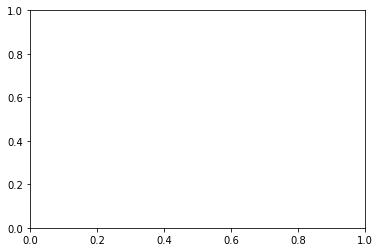

In [29]:
# Save history for later
train_loss_history = train_losses
valid_loss_history = valid_losses

# Plot training and validation curve
x = range(1, num_epochs + 1)
plt.plot(x, train_loss_history, label='train')
plt.plot(x, valid_loss_history, label='valid')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()